In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PIL.Image
import cv2
from tqdm.auto import tqdm
import math

/home/torfinhell/.conda/envs/DL/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
BATCH_SIZE=32
WINDOW_SIZE=(100, 100)
if(torch.cuda.is_available()):
    DEVICE=torch.device("cuda")
else:
    DEVICE=torch.device("cpu")

In [3]:
import torchvision.transforms.v2 as T
TRANSFORM=T.Compose([
        T.ToTensor(),
        T.Resize(size=WINDOW_SIZE)
    ]   
)

/home/torfinhell/.conda/envs/DL/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [4]:
from torch.utils import data 
import random
class MyDataset(data.Dataset):
    def __init__(self,
                 mode, 
                 root_images, 
                 root_images_info,
                 train_fraction=0.8, 
                 split_seed=42,
                 transform=None):
        super().__init__()
        rng=random.Random(split_seed)
        image_info=pd.read_csv(root_images_info+"/img_shapes.csv")
        image_info_points=pd.read_csv(root_images_info+"/gt.csv")
        self.paths=list(image_info['img_filename'])
        self.shapes=list(zip(image_info['n_rows'], image_info['n_cols']))
        self.points=[list(row.iloc[1:]) for _, row in image_info_points.iterrows()]
        self.points=list(map(lambda x: [[x[i], x[i+1]] for i in range(0,len(x), 2)], self.points))
        combined = list(zip(self.paths, self.shapes, self.points))
        rng.shuffle(combined)
        self.paths, self.shapes, self.points = zip(*combined)
        split_train=int(train_fraction*len(self.paths))
        if(mode=="train"):
            self.paths=self.paths[:split_train]
            self.shapes=self.shapes[:split_train]
            self.points=self.points[:split_train]
        elif(mode=="valid"):
            self.paths=self.paths[split_train:]
            self.shapes=self.shapes[split_train:]
            self.points=self.points[split_train:]
        else:
            raise ValueError("Mode is not train or valid")
        self.paths=[f"{root_images}/{path}" for path in self.paths]

        self._transform=transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, index):
        img_path=self.paths[index]
        label=self.points[index]
        if(self._transform):
            old_shape=self.shapes[index]
            image=np.array(self._transform(np.array(PIL.Image.open(img_path))))
            new_shape=image.shape[1:]
            scale1, scale2=old_shape[0]/new_shape[0], old_shape[1]/new_shape[1]
            label=[(int(x/scale1), int(y/scale2)) for x, y in label]
        else:
            image=np.array(PIL.Image.open(img_path))
        label=np.array(label)
        return image, label

In [5]:
import os
image_dir="./tests/00_test_img_input/train/images"#test is the same as train
file_points="./tests/00_test_img_gt"
ds_train=MyDataset("train", image_dir, file_points, transform=TRANSFORM)
ds_valid=MyDataset("valid", image_dir, file_points, transform=TRANSFORM)

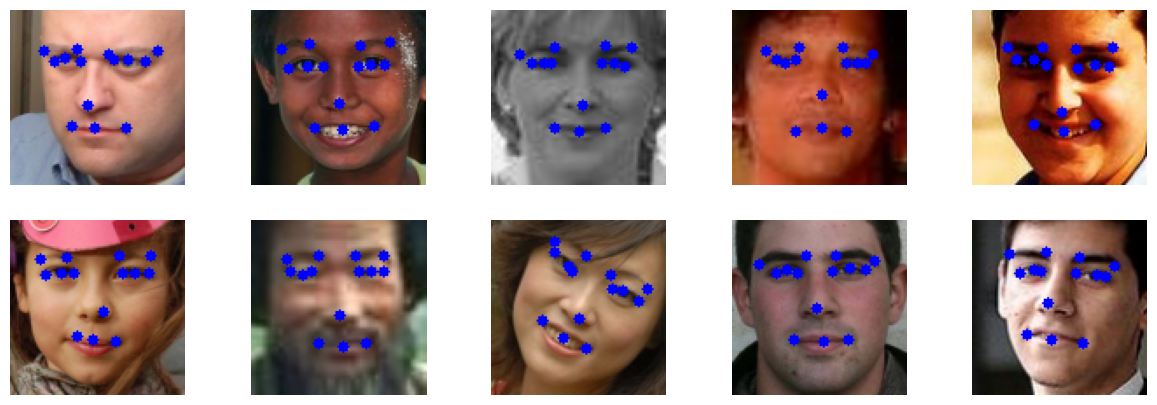

In [6]:
def reverse_transform(tensor, mean=None, std=None):
    if(std is not None):
        tensor*=std[:,None, None]
    if(mean is not None):
        tensor+=mean[:, None, None]
    tensor*=255
    tensor=np.clip(tensor, 0, 255)
    tensor = np.transpose(tensor, (1, 2, 0))
    return tensor.astype(np.uint8)
def show_image_points(tensor_image, points,color = (0, 0, 255), mean=None, std=None):
    ''' 
    Takes in numy array returns Pil Image with points on them
    '''
    if(isinstance(tensor_image,PIL.Image.Image)):
        tensor_image=np.array(tensor_image).copy()
    image=reverse_transform(tensor_image, mean, std).copy()
    r=3
    for point in points:
        cv2.circle(image, point, r, color, -1)
    return PIL.Image.fromarray(image)
def display_multiple_images(dataset, n=5, mean=None, std=None):
    plt.figure(figsize=(15, 5))
    cols = min(n, 5)
    rows=math.ceil(n/cols)
    for i in range(n):
        tensor_image, points=dataset[i]
        image=show_image_points(tensor_image, points, mean=mean, std=std)
        plt.subplot(rows,cols, i+1)
        plt.imshow(image)
        plt.axis("off")
display_multiple_images(ds_train, 10)

In [7]:
def calculate_mean_std(ds_train):
    mean=0.
    std=0.
    for image, _ in ds_train:
        mean+=image.mean((1, 2))
        std+=image.std((1, 2))
    mean/=len(ds_train)
    std/=len(ds_train)
    return mean, std
MEAN_DATASET, STD_DATASET = calculate_mean_std(ds_train)
MEAN_DATASET, STD_DATASET

(array([0.53659433, 0.43041748, 0.37608618], dtype=float32),
 array([0.23250134, 0.21281327, 0.20285839], dtype=float32))

In [8]:
NEW_TRANSFORM=T.Compose([
    T.ToTensor(),
    T.Resize(size=WINDOW_SIZE),
    T.Normalize(MEAN_DATASET, STD_DATASET)
]
)
ds_train=MyDataset("train", image_dir, file_points, transform=NEW_TRANSFORM)
ds_valid=MyDataset("valid", image_dir, file_points, transform=NEW_TRANSFORM)

/home/torfinhell/.conda/envs/DL/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


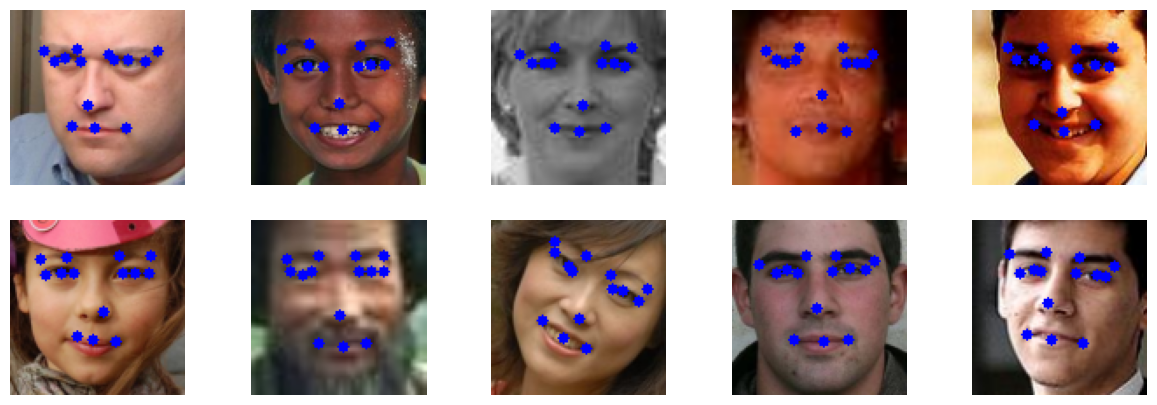

In [9]:
display_multiple_images(ds_train, 10, MEAN_DATASET, STD_DATASET)

In [10]:
dl_train=data.DataLoader(
    ds_train, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=os.cpu_count()
)
dl_valid=data.DataLoader(
    ds_valid, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=os.cpu_count()
)

In [23]:
class MyModel(nn.Sequential):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3, 64, 3, padding=1)
        self.bn1=nn.BatchNorm2d(64)
        self.relu1=nn.ReLU()
        self.maxpooling1=nn.MaxPool2d(2)
        self.conv2=nn.Conv2d(64, 128, 3, padding=1)
        self.bn2=nn.BatchNorm2d(128)
        self.relu2=nn.ReLU()
        self.maxpooling2=nn.MaxPool2d(2)
        self.conv3=nn.Conv2d(128, 256, 3, padding=1)
        self.bn3=nn.BatchNorm2d(256)
        self.relu3=nn.ReLU()
        self.maxpooling3=nn.MaxPool2d(2)
        self.flatten=nn.Flatten()
        self.dense=nn.Linear(256 * (WINDOW_SIZE[0]//8) * (WINDOW_SIZE[1]//8), 100)
        self.relu4=nn.ReLU(),
        nn.Dropout(0.1),
        self.dense1=nn.Linear(100, 28)

In [ ]:
def train(num_epochs=3):
    model=MyModel().to(DEVICE)
    loss_fn=torch.nn.MSELoss().to(DEVICE)
    optimizer=torch.optim.AdamW(model.parameters(), lr=1e-3)
    for e in range(num_epochs):
        model.train()
        train_loss=[]
        for x_batch, y_batch in dl_train:
            x_batch=x_batch.to(DEVICE)
            y_batch=y_batch.to(torch.float32)
            y_batch=y_batch.reshape(y_batch.shape[0], -1).to(DEVICE)
            p_batch=model(x_batch)
            loss=loss_fn(p_batch, y_batch)
            train_loss.append(loss.detach())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        train_loss=torch.stack(train_loss).mean()
        print(
            f"Epoch {e},",
            f"train_loss: {(train_loss.item()):.8f}",
        )
        model.eval()
        valid_accs = []
        for x_batch, y_batch in dl_valid:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            with torch.no_grad():
                p_batch = model(x_batch)
            y_batch=y_batch.reshape(y_batch.shape[0], -1)
            loss=loss_fn(p_batch, y_batch)
            valid_accs.append(loss.detach())
        valid_accs = torch.stack(valid_accs).mean()
        print(
            f"Epoch {e},",
            f"valid_loss: {valid_accs.item():.8f}",
        )
    return model


In [27]:
if(DEVICE==torch.device("cuda:0")):
    torch.cuda.empty_cache()
model=train(num_epochs=40)

Epoch 0, train_loss: 64.18831635
Epoch 0, valid_loss: 23.86133766
Epoch 1, train_loss: 22.26586723
Epoch 1, valid_loss: 20.17886162
Epoch 2, train_loss: 20.71362495
Epoch 2, valid_loss: 21.00794029
Epoch 3, train_loss: 19.23004913
Epoch 3, valid_loss: 19.01388931
Epoch 4, train_loss: 18.01559830
Epoch 4, valid_loss: 18.15454102
Epoch 5, train_loss: 17.00032997
Epoch 5, valid_loss: 16.95880318
Epoch 6, train_loss: 16.06591415
Epoch 6, valid_loss: 19.72177124
Epoch 7, train_loss: 15.20253944
Epoch 7, valid_loss: 15.80996037
Epoch 8, train_loss: 13.74783897
Epoch 8, valid_loss: 18.68830490
Epoch 9, train_loss: 12.88009930
Epoch 9, valid_loss: 15.91101456
Epoch 10, train_loss: 12.19320011
Epoch 10, valid_loss: 13.96473312
Epoch 11, train_loss: 11.06591320
Epoch 11, valid_loss: 15.26088142
Epoch 12, train_loss: 10.88060856
Epoch 12, valid_loss: 15.44432831
Epoch 13, train_loss: 10.18681335
Epoch 13, valid_loss: 18.18244553
Epoch 14, train_loss: 10.18066311
Epoch 14, valid_loss: 14.25969028


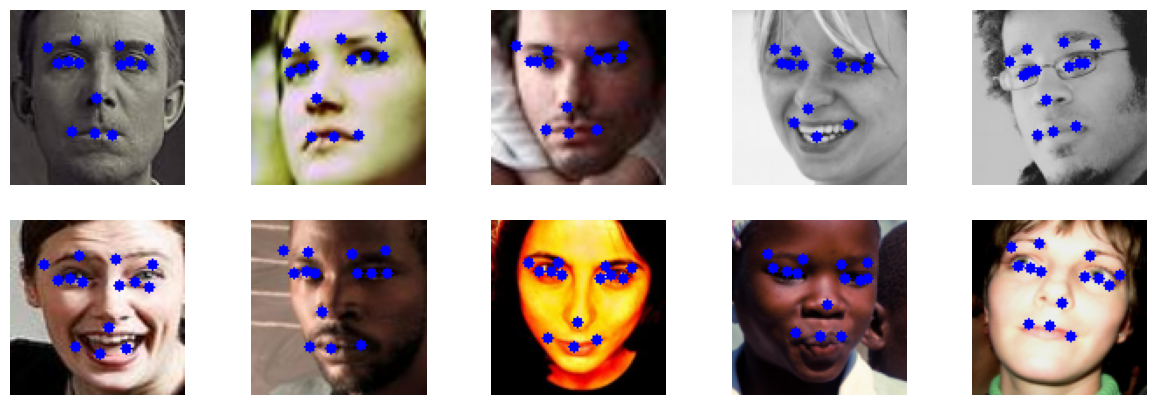

In [20]:
def display_model_results(model, dataset, n=5, mean=None, std=None):
    model.eval()
    plt.figure(figsize=(15, 5))
    cols = min(n, 5)
    rows=math.ceil(n/cols)
    for i in range(n):
        image, _=dataset[i]
        with torch.no_grad():
            tensor_image=torch.tensor(image).unsqueeze(0).to(DEVICE)
            pred=model(tensor_image).squeeze().tolist()
        pred=np.array([[pred[i], pred[i+1]] for i in range(0,len(pred), 2)]).astype(np.int64)
        image=show_image_points(image, pred, mean=mean,std=std)
        plt.subplot(rows,cols, i+1)
        plt.imshow(image)
        plt.axis("off")
display_model_results(model, ds_valid, n=10, mean=MEAN_DATASET, std=STD_DATASET)

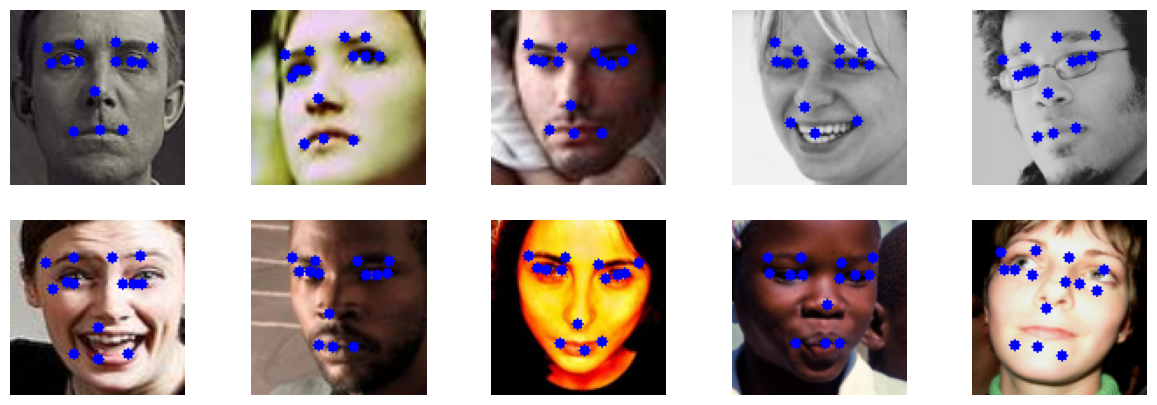

In [21]:
display_multiple_images(ds_valid, n=10, mean=MEAN_DATASET, std=STD_DATASET)

In [22]:
torch.save(model.to('cpu').state_dict(), "facepoints_model.pt")